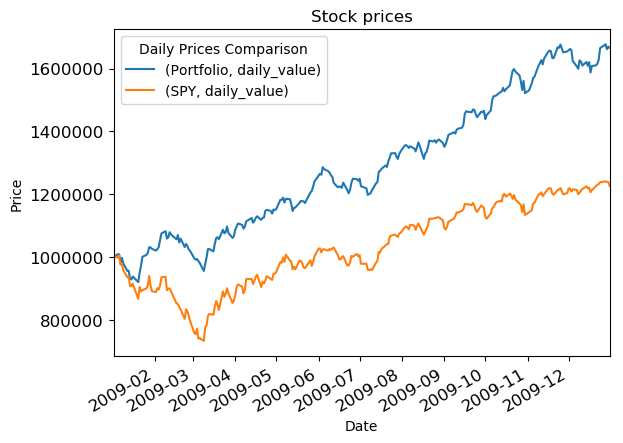

Start Date: 2009-01-01 00:00:00
End Date: 2010-01-01 00:00:00
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [0.2, 0.3, 0.4, 0.1]
Sharpe Ratio: 27.960707768102154
Volatility (stdev of daily returns): 0.01191092303593521
Average Daily Return: 0.00209794118381024
Cumulative Return: [0.6657866]


In [1]:
"""Analyze a portfolio.

Copyright 2017, Georgia Tech Research Corporation
Atlanta, Georgia 30332-0415
All Rights Reserved
"""

import datetime as dt

import numpy as np

import pandas as pd
from util import get_data, plot_data


# This is the function that will be tested by the autograder
# The student must update this code to properly implement the functionality
def assess_portfolio(
        sd=dt.datetime(2008, 1, 1),
        ed=dt.datetime(2009, 1, 1),
        syms=["GOOG", "AAPL", "GLD", "XOM"],
        allocs=[0.1, 0.2, 0.3, 0.4],
        sv=1_000_000,
        rfr=0.0,
        sf=252.0,  # sampling freq or trading days
        gen_plot=False,
):
    """
    Estimate a set of test points given the model we built.

    :param sd: A datetime object that represents the start date, defaults to 1/1/2008
    :type sd: datetime
    :param ed: A datetime object that represents the end date, defaults to 1/1/2009
    :type ed: datetime
    :param syms: A list of 2 or more symbols that make up the portfolio (note that your code should support any symbol in the data directory)
    :type syms: list
    :param allocs:  A list of 2 or more allocations to the stocks, must sum to 1.0
    :type allocs: list
    :param sv: The starting value of the portfolio
    :type sv: int
    :param rfr: The risk free return per sample period that does not change for the entire date range (a single number, not an array)
    :type rfr: float
    :param sf: Sampling frequency per year
    :type sf: float
    :param gen_plot: If True, optionally create a plot named plot.png. The autograder will always call your
        code with gen_plot = False.
    :type gen_plot: bool
    :return: A tuple containing the cumulative return, average daily returns,
        standard deviation of daily returns, Sharpe ratio and end value
    :rtype: tuple
    """

    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    # prices_all is a df
    prices_all = get_data(syms, dates)  # automatically adds SPY
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all["SPY"]  # only SPY, for comparison later

    # Get daily portfolio value
    # port_val = prices_SPY  # add code here to compute daily portfolio values
    # day one divide the sv by alloc over the portfolio should sum to sv
    # I now have num shares for each stock, using this calculate pv on each day
    # print(f'prices_all shape: {prices_all.shape}, prices_all[0]: {prices_all.iloc[0].values}')

    normed = prices / prices.iloc[0].values
    # has dates
    normed = pd.DataFrame(normed)
    allocs = np.asarray(allocs)

    alloced = normed * allocs
    pos_vals = alloced * sv
    port_vals = pos_vals.sum(axis=1)

    # do same for SPY but not sum
    '''
    normedSPY = pd.DataFrame(prices_SPY)
    allocedSPY = normedSPY.values * 1.0
    pos_valsSPY = allocedSPY * sv
    pos_valsSPY = pd.DataFrame(pos_valsSPY)
    '''


    # day_i / day_(i-1) - 1
    daily_rets = [((port_vals[i] / port_vals[i - 1]) - 1) for i in range(1, len(port_vals))]
    daily_rets = [0] + daily_rets
    daily_rets = np.asarray(daily_rets)
    assert len(daily_rets) == len(port_vals)

    # todo: do the daily rets for SPY then make another dataframe start at 1m and use the daily rets
    #  to fill in values.

    drspy = [((prices_SPY[i] / prices_SPY[i - 1]) - 1) for i in range(1, len(prices_SPY))]
    drspy = [0] + drspy
    firstColName = 'values_spy'
    prices_SPY = pd.DataFrame(prices_SPY.values,index=prices_SPY.index, columns=[firstColName])
    #drspy = np.asarray(drspy)
    prices_SPY.drop(firstColName, axis=1, inplace=True)
    prices_SPY[firstColName] = drspy
    spyVal, dailySpyValsDf = calculateSPYEndValFromSV(prices_SPY, startingValue=1_000_000)

    # Get portfolio statistics (note: std_daily_ret = volatility)
    # cumulative return, average daily returns,
    # standard deviation of daily returns, Sharpe ratio and end value
    cr, adr, sddr, sr = [
        0.25,
        0.001,
        0.0005,
        2.1,
    ]  # add code here to compute stats
    port_vals = pd.DataFrame(port_vals, columns=['daily_value'])
    cr = (port_vals.iloc[-1].values / port_vals.iloc[0].values) - 1
    adr = daily_rets.mean()
    sddr = daily_rets.std()
    sharpeRatioAdjustment = np.sqrt(sf)
    # 10 basis points is 1 percent
    basis_pt_factor = 10.
    sr = sharpeRatioAdjustment * ((adr * basis_pt_factor - (calculate_daily_rf(rfr, sf) * basis_pt_factor)) / daily_rets.std())


    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        dailySpyValsDf.rename(columns={dailySpyValsDf.columns[0]: 'daily_value'}, inplace=True)

        df_temp = pd.concat(
            [port_vals, dailySpyValsDf], keys=["Portfolio", "SPY"], axis=1
        )
        df_dates = df_temp.loc[sd:ed]

        df_dates.to_csv('portVsSpy.csv', index=True)
        plot_data(df_dates, title="Stock prices", xlabel="Date", ylabel="Price")

    # Add code here to properly compute end value
    ev = port_vals['daily_value'].iloc[-1]
    #ev = np.asarray(port_vals)[-1][0]

    return cr, adr, sddr, sr, ev


def calculateSPYEndValFromSV(dailyReturnSPY, startingValue=1_000_000):
    '''
    dailyReturnSPY is the daily return of spy, now multiply by each days's return + 1 since there
    negative values to get a final value and return
    also need each day's value for plot
    '''
    firstColAsList = dailyReturnSPY.iloc[:, 0].tolist()
    spyDailyVal = [0 for x in range(len(firstColAsList))]
    spyDailyVal[0] = startingValue
    for i in range(1, dailyReturnSPY.shape[0]):
        dr = dailyReturnSPY.iat[i, 0]
        dailyReturn = dailyReturnSPY.iloc[i,:].values[0]
        spyDailyVal[i] = spyDailyVal[i-1] * (1+dailyReturn)
    '''
    for idx, row in dailyReturnSPY.iterrows():
        dailyReturn = row.values[0]
        spyDailyVal[idx] = spyDailyVal[idx-1] * (1+dailyReturn)
    '''
    finalValue = spyDailyVal[-1]
    firstColName = dailyReturnSPY.columns[0]
    dailyReturnSPY.drop(firstColName, axis=1, inplace=True)
    dailyReturnSPY[firstColName] = spyDailyVal

    return finalValue, dailyReturnSPY


def calculate_daily_rf(rfr, sf=252.0):
    if rfr < -1.0:
        raise ValueError("Risk-free rate cannot be negative.")
    if sf <= 0.0:
        raise ValueError("Sampling frequency must be positive.")
    daily_rf = ((1 + rfr) ** (1 / sf)) - 1.0

    return daily_rf



def test_code():
    """
    Performs a test of your code and prints the results
    """
    # This code WILL NOT be tested by the auto grader
    # It is only here to help you set up and test your code

    # Define input parameters
    # Note that ALL of these values will be set to different values by
    # the autograder!
    start_date = dt.datetime(2009, 1, 1)
    end_date = dt.datetime(2010, 1, 1)
    symbols = ["GOOG", "AAPL", "GLD", "XOM"]
    allocations = [0.2, 0.3, 0.4, 0.1]
    start_val = 1000000
    risk_free_rate = 0.0
    sample_freq = 252

    # Assess the portfolio
    cr, adr, sddr, sr, ev = assess_portfolio(
        sd=start_date,
        ed=end_date,
        syms=symbols,
        allocs=allocations,
        sv=start_val,
        gen_plot=True,
    )

    # Print statistics
    print(f"Start Date: {start_date}")
    print(f"End Date: {end_date}")
    print(f"Symbols: {symbols}")
    print(f"Allocations: {allocations}")
    print(f"Sharpe Ratio: {sr}")
    print(f"Volatility (stdev of daily returns): {sddr}")
    print(f"Average Daily Return: {adr}")
    print(f"Cumulative Return: {cr}")


if __name__ == "__main__":
    test_code()


In [1]:
sd=dt.datetime(2008, 1, 1)
ed=dt.datetime(2009, 1, 1)

dates = pd.date_range(sd, ed)


NameError: name 'dt' is not defined